In [1]:
import numpy as np
import xray
import os
import re
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
ddir = '/data/scratch/rpa/channel_moc/GCM/run'

In [3]:
def parse_available_diagnostics(fname):
    all_diags = {}
    with open(fname) as f:
        # will automatically skip first four header lines
        for l in f:
            c = re.split('\|',l)
            if len(c)==7 and c[0].strip()!='Num':
                key = c[1].strip()
                levs = int(c[2].strip())
                mate = c[3].strip()
                if mate: mate = int(mate) 
                code = c[4]
                units = c[5].strip()
                desc = c[6].strip()
                all_diags[key] = MITgcmDiagnosticDescription(
                    key, code, units, desc, levs, mate)
    return all_diags
            
class MITgcmDiagnosticDescription(object):
    
    def __init__(self, key, code, units=None, desc=None, levs=None, mate=None):
        self.key = key
        self.levs = levs
        self.mate = mate
        self.code = code
        self.units = units
        self.desc = desc
    
    def coords(self):
        """Parse code to determine coordinates."""
        hpoint = self.code[1]
        rpoint = self.code[8]
        rlev = self.code[9]
        xcoords = {'U': 'XG', 'V': 'XC', 'M': 'XC', 'Z': 'XG'}
        ycoords = {'U': 'YC', 'V': 'YG', 'M': 'YC', 'Z': 'YG'}
        rcoords = {'M': 'RC', 'U': 'RFu', 'L': 'RFl'}
        if rlev=='1':
            return (ycoords[hpoint], xcoords[hpoint])
        elif rlev=='R':
            return (rcoords[rpoint], ycoords[hpoint], xcoords[hpoint])
        else:
            raise ValueError("Don't know what to do with rlev = " + rlev)
        
      

In [68]:
all_diags = parse_available_diagnostics(os.path.join(ddir, 'available_diagnostics.log'))

In [71]:
diag = all_diags['UDIAG9']

In [72]:
diag.coords()

ValueError: Don't know what to do with rlev = L

In [5]:
print all_diags['PHIBOT'].coords()
print all_diags['PHIBOT'].code


('YC', 'XC')
SM      M1


In [6]:
def parse_meta(fname):
    flds = {}
    basename = re.match('(^\w+)', os.path.basename(fname)).groups()[0]
    flds['basename'] = basename
    with open(fname) as f:
        text = f.read()
    # split into items
    for item in re.split(';', text):
        # remove whitespace at beginning
        item = re.sub('^\s+', '', item)
        #match = re.match('(\w+) = ', item)
        match = re.match('(\w+) = (\[|\{)(.*)(\]|\})', item, re.DOTALL)
        if match:
            key, _, value, _ = match.groups()
            # remove more whitespace
            value = re.sub('^\s+', '', value)
            value = re.sub('\s+$', '', value)
            #print key,':', value
            flds[key] = value
    # now check the needed things are there
    needed_keys = ['dimList','nDims','nrecords','dataprec']
    for k in needed_keys:
        assert flds.has_key(k)
    # transform datatypes
    #print flds
    flds['nDims'] = int(flds['nDims'])
    flds['nrecords'] = int(flds['nrecords'])
    # use big endian always
    flds['dataprec'] = np.dtype(re.sub("'",'',flds['dataprec'])).newbyteorder('>')
    flds['dimList'] = [[int(h) for h in
                       re.split(',', g)] for g in
                       re.split(',\n',flds['dimList'])]
    if flds.has_key('fldList'):
        flds['fldList'] = [re.match("'*(\w+)",g).groups()[0] for g in
                           re.split("' '",flds['fldList'])]
        assert flds['nrecords'] == len(flds['fldList'])
    return flds

In [7]:
def read_mds(fname, iternum=None, use_mmap=True,
             force_dict=False, convert_big_endian=False):
    if iternum is None:
        istr = ''
    else:
        assert isinstance(iternum, int)
        istr = '.%010d' % iternum
    datafile = fname + istr + '.data'
    metafile = fname + istr + '.meta'
    
    # get metadata
    meta = parse_meta(metafile)
    # why does the .meta file contain so much repeated info?
    # just get the part we need
    # and reverse order (numpy uses C order, mds is fortran)
    shape = [g[0] for g in meta['dimList']][::-1]
    assert len(shape) == meta['nDims']
    # now add an extra for number of recs
    nrecs = meta['nrecords']
    shape.insert(0, nrecs)
    
    # load and shape data
    if use_mmap:
        d = np.memmap(datafile, meta['dataprec'], 'r')
    else:
        d = np.fromfile(datafile, meta['dataprec'])
    if convert_big_endian:
        dtnew = d.dtype.newbyteorder('=')
        d = d.astype(dtnew)
        
    d.shape = shape
    
    if nrecs == 1:
        if meta.has_key('fldList'):
            name = meta['fldList'][0]
        else:
            name = meta['basename']
        if force_dict:
            return {name: d[0]}
        else:
            return d[0]
    else:
        # need record names
        out = {}
        for n, name in enumerate(meta['fldList']):
            out[name] = d[n]
        return out

In [8]:
ds = xray.Dataset()

grid_files = ['XC','XG','YG','YG','RC','RF']
geom_files = ['DXC','DXG','DYC','DYG','DRF','DRF','RAC','RAS','RAW','RAZ','hFacC','hFacS','hFacW']

def grid_path(vname):
    return os.path.join(ddir, vname)

# 1D orthogonal dimensions
# This is valid for cartesian geometry only!
# ( and maybe spherical polar grid)
ds.coords['XC'] = ('XC', read_mds(grid_path('XC'))[0,:])
ds.coords['XG'] = ('XG', read_mds(grid_path('XG'))[0,:])
ds.coords['YC'] = ('YC', read_mds(grid_path('YC'))[:,0])
ds.coords['YG'] = ('YG', read_mds(grid_path('YG'))[:,0])
ds.coords['RC'] = ('RC', read_mds(grid_path('RC'))[:,0,0])
ds.coords['RF'] = ('RF', read_mds(grid_path('RF'))[:,0,0])
# these are for actual variables
ds.coords['RFl'] = ('RFl', read_mds(grid_path('RF'))[:-1,0,0])
ds.coords['RFu'] = ('RFu', read_mds(grid_path('RF'))[1:,0,0])

# 2D and 3D grid variables
ds.coords['RAC'] = (('YC','XC'), read_mds(grid_path('RAC')))
ds.coords['RAZ'] = (('YG','XG'), read_mds(grid_path('RAC')))
# what about RAS and RAW?

ds.coords['HFACC'] = (('RC','YC','XC'), read_mds(grid_path('hFacC')))
ds.coords['HFACS'] = (('RC','YG','XC'), read_mds(grid_path('hFacS')))
ds.coords['HFACW'] = (('RC','YC','XG'), read_mds(grid_path('hFacW')))


ds

<xray.Dataset>
Dimensions:  (RC: 40, RF: 41, RFl: 40, RFu: 40, XC: 200, XG: 200, YC: 400, YG: 400)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * RC       (RC) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * RF       (RF) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * RFl      (RFl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * RFu      (RFu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    RAC      (YC, XC) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    RAZ      (YG, XG) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    HFACC    (RC, YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HFACS    (RC, YG, XC

In [22]:
ls /data/scratch/rpa/channel_moc/GCM/run

available_diagnostics.log         STDOUT.0011
bathyFile.bin                     STDOUT.0012
channel.e25947                    STDOUT.0013
channel.e25956                    STDOUT.0014
channel.e25975                    STDOUT.0015
channel.e42286                    STDOUT.0016
channel.e44034                    STDOUT.0017
channel.e49731                    STDOUT.0018
channel.e50368                    STDOUT.0019
channel.e618856                   STDOUT.0020
channel.e618861                   STDOUT.0021
channel.e618862                   STDOUT.0022
channel.e618863                   STDOUT.0023
channel.e618865                   STDOUT.0024
channel.e618866                   STDOUT.0025
channel.e618868                   STDOUT.0026
channel.e618873                   STDOUT.0027
channel.o25947                    STDOUT.0028
channel.o25956                    STDOUT.0029
channel.o25975                    STDOUT.0030
channel.o42286                    STDOUT.0031
channel.o44034                    

### Diagnostic Parsing Array ###
Array | Value | Description
------|-------|-------
1 | S | Scalar Diagnostic
  | U | U-vector component Diagnostic
  | V | V-vector component Diagnostic
2 | U | C-Grid U-Point
  | V | C-Grid V-Point
  | M | C-Grid Mass Point
  | Z | C-Grid Vorticity (Corner) Point
3 |	  |Used for Level Integrated output: cumulate levels
  | r | same but cumulate product by model level thickness
  | R | same but cumulate product by hFac & level thickness
4 | P | Positive Definite Diagnostic
5 | C | with Counter array
  | P | post-processed (not filled up) from other diags
  | D | Disabled Diagnostic for output
6-8|  | retired, formerly: 3-digit mate number
9 | U | model-level plus 1/2
  | M | model-level middle
  | L | model-level minus 1/2
10| 0 | levels = 0
  | 1 | levels = 1
  | R | levels = Nr
  | L | levels = MAX(Nr,NrPhys)
  | M | levels = MAX(Nr,NrPhys) - 1
  | G | levels = Ground_level Number
  | I | levels = sea-Ice_level Number
  | X | free levels option (need to be set explicitly)


In [9]:
state_vars = {
    'U': MITgcmDiagnosticDescription(
         'U', 'UUR     MR', 'm/s', 'Zonal Component of Velocity (m/s)'),
    'V': MITgcmDiagnosticDescription(
         'V', 'VVR     MR', 'm/s', 'Meridional Component of Velocity (m/s)'),
    'W': MITgcmDiagnosticDescription(
         'W', 'WM      LR', 'm/s', 'Vertical Component of Velocity (r_units/s)'),
    'T': MITgcmDiagnosticDescription(
         'T', 'SMR     MR', 'degC', 'Potential Temperature'),
    'S': MITgcmDiagnosticDescription(
         'S', 'SMR     MR', 'psu', 'Salinity'),
    'PH': MITgcmDiagnosticDescription(
          'PH', 'SMR     MR', 'm^2/s^2', 'Hydrostatic Pressure Pot.(p/rho) Anomaly'),
    'PHL': MITgcmDiagnosticDescription(
          'PHL', 'SM      M1', 'm^2/s^2', 'Bottom Pressure Pot.(p/rho) Anomaly'),
    'Eta': MITgcmDiagnosticDescription(
          'Eta', 'SM      M1', 'm', 'Surface Height Anomaly'),
}

In [10]:
iternum = 1728000
for k, v in state_vars.iteritems():
    data = read_mds(grid_path(k), iternum)
    ds[k] = (v.coords(), data)
    ds[k].attrs = {'description': v.desc, 'units': v.units}

In [11]:
ds

<xray.Dataset>
Dimensions:  (RC: 40, RF: 41, RFl: 40, RFu: 40, XC: 200, XG: 200, YC: 400, YG: 400)
Coordinates:
  * XC       (XC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * XG       (XG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * YC       (YC) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * YG       (YG) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * RC       (RC) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * RF       (RF) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * RFl      (RFl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * RFu      (RFu) >f4 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
    RAC      (YC, XC) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    RAZ      (YG, XG) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    HFACC    (RC, YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    HFACS    (RC, YG, XC

### Time-average variables ##

    Convtave
    Eta2tave
    ETAtave
    PhHytave
    PHL2tave
    PHLtave
    sFluxtave
    Stave
    Tdiftave
    tFluxtave
    Ttave
    TTtave
    uFluxtave
    UStave
    UTtave
    UUtave
    uVeltave
    UVtave
    vFluxtave
    VStave
    VTtave
    vVeltave
    VVtave
    WStave
    WTtave
    wVeltave

In [26]:
ds['T'] * ds['PH']

<xray.DataArray (RC: 40, YC: 400, XC: 200)>
array([[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -4.77954578e+00,  -4.76554441e+00,  -4.78610754e+00, ...,
          -4.81507158e+00,  -4.79722786e+00,  -4.78228283e+00],
        [ -4.84008884e+00,  -4.74809980e+00,  -4.76202965e+00, ...,
          -7.01163149e+00,  -6.23767376e+00,  -5.15652132e+00],
        ..., 
        [  7.88622284e+01,   7.88518372e+01,   7.88433609e+01, ...,
           7.89076462e+01,   7.88900146e+01,   7.88750000e+01],
        [  7.90084534e+01,   7.90063934e+01,   7.90049820e+01, ...,
           7.90169601e+01,   7.90140305e+01,   7.90109100e+01],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]],

       [[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [ -4.704

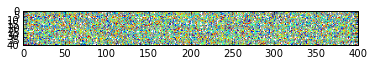

In [27]:
plt.imshow(ds['T'].mean(dim='XC'))

In [356]:
x = xray.DataArray( np.ones(10, dtype='>f4'))
print float(x.sum()), x.data.sum()

4.60060298822e-40 10.0


In [355]:
np.ones(10)#, dtype='>4f')

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [7]:
dt = np.dtype('>f4')
dt

dtype('>f4')

In [28]:
type(ds['T'].data)

numpy.ndarray

In [9]:
dtnew

dtype('float32')

In [30]:
import bottleneck as bn
bn.bench()

Bottleneck performance benchmark
    Bottleneck  1.0.0
    Numpy (np)  1.9.2
    Speed is NumPy time divided by Bottleneck time
    NaN means approx one-third NaNs; float64 and axis=-1 are used

                 no NaN     no NaN      NaN        NaN    
                   (10,)   (1000,1000)   (10,)   (1000,1000)
    nansum         39.8        2.7       39.5        6.6
    nanmean       151.0        3.9      151.0        8.1
    nanstd        271.8        2.8      271.5        6.7
    nanvar        257.6        2.8      256.9        6.7
    nanmin         33.1        1.0       32.9        1.4
    nanmax         33.1        1.0       32.9        2.1
    median         38.3        0.8       40.2        1.0
    nanmedian      48.2        3.8       55.3       10.9
    ss             14.8        1.3       14.8        1.3
    nanargmin      63.5        3.6       63.7        8.8
    nanargmax      64.4        3.5       64.8        9.8
    anynan         14.6        0.5       14.8       46.2
 

In [156]:
import mdsxray
reload(mdsxray)

<module 'mdsxray' from 'mdsxray.py'>

In [158]:
store = mdsxray.MDSDataStore(ddir)
ds = xray.Dataset.load_store(store)
ds

<xray.Dataset>
Dimensions:  (X: 200, Xp1: 200, Y: 400, Yp1: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 39)
Coordinates:
  * Xp1      (Xp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Yp1      (Yp1) >f4 0.0 5000.0 10000.0 15000.0 20000.0 25000.0 30000.0 ...
  * Zp1      (Zp1) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Y        (Y) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * X        (X) >f4 2500.0 7500.0 12500.0 17500.0 22500.0 27500.0 32500.0 ...
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 -42.0 -56.0 -72.0 -91.0 -113.0 ...
  * Zu       (Zu) >f4 -15.0 -25.0 -36.0 -49.0 -64.0 -81.5 -102.0 -126.0 ...
Data variables:
    YC       (Y, X) >f4 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 2500.0 ...
    YG       (Yp1, Xp1) >f4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    rA       (Y, X) >f4 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 2.5e+07 ...
    dxG     

In [126]:
rAz = store.get_variables()['rAz']

In [142]:
store._variables['rAz']

<xray.Variable (Yp1: 400, Xp1: 200)>
array([[ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.],
       [ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.],
       [ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.],
       ..., 
       [ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.],
       [ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.],
       [ 25000000.,  25000000.,  25000000., ...,  25000000.,  25000000.,
         25000000.]], dtype=float32)
Attributes:
    units: m^2
    description: r-face area at cell corner

In [61]:
xc = read_mds(grid_path('XC'))
xg = read_mds(grid_path('XG'))
yc = read_mds(grid_path('YC'))
xcd = da.from_array(xc, xc.shape)
xgd = da.from_array(xg, xg.shape)
ycd = da.from_array(yc, yc.shape)


In [54]:
import dask.array as da

In [63]:
dstacked = da.stack([xcd, xgd, ycd])

In [64]:
dstacked

dask.array<stack-1, shape=(3, 400, 200), chunks=((1, 1, 1), (400,), (200,)), dtype=float32>

In [136]:
type(np.asarray(xc))

numpy.ndarray

In [143]:
from xray.backends import ScipyDataStore

In [144]:
sds = ScipyDataStore('/data/scratch/rpa/aviso/ftp.aviso.altimetry.fr/global/delayed-time/grids/msla/all-sat-merged/uv/all-monthly/dt_global_allsat_msla_uv_2014-12.nc')

In [149]:
sds.get_variables()['lat_bnds']

<xray.Variable (lat: 720, nv: 2)>
array([[-89.75, -90.  ],
       [-89.5 , -89.75],
       [-89.25, -89.5 ],
       ..., 
       [ 89.5 ,  89.25],
       [ 89.75,  89.5 ],
       [ 90.  ,  89.75]], dtype=float32)